<a href="https://colab.research.google.com/github/mafaldasalomao/DCGAN_MNIST_TENSORFLOW/blob/main/DCGAN_MNIST_TENSORFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.9.2'

In [2]:
(X_treinamento, y_treinamento), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_treinamento.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [6]:
y_treinamento.shape

(60000,)

In [7]:
i = np.random.randint(0, 60000)
i

12079

2


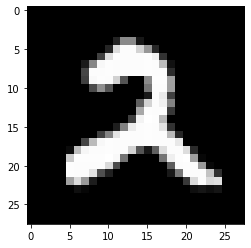

In [8]:
plt.imshow(X_treinamento[i], cmap='gray');
print(y_treinamento[i])

In [9]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')
X_treinamento.shape

(60000, 28, 28, 1)

In [10]:
X_treinamento[0].min(), X_treinamento.max()

(0.0, 255.0)

In [11]:
X_treinamento = (X_treinamento -127.5)/127.5

In [12]:
X_treinamento[0].min(), X_treinamento.max()

(-1.0, 1.0)

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size/batch_size

234.375

In [15]:
type(X_treinamento)

numpy.ndarray

In [16]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_treinamento)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
#construct generator
def cria_gerador():
  network = tf.keras.Sequential()
  network.add(layers.Dense(units = 7*7*256, use_bias=False, input_shape=(100, )))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7, 7, 256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5, 5), padding= 'same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5, 5), padding= 'same', use_bias=False, strides=(2, 2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x 28 x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5, 5), padding='same', use_bias=False, strides=(2, 2), activation='tanh'))

  network.summary()
  return network

In [19]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [20]:
#100 numbers radon linked to 12544 neurons
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [21]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.49133536,  0.2566584 ,  0.4777906 ,  0.9676377 ,  0.5793581 ,
        -1.2587771 , -0.3043676 , -0.3868905 , -0.11483239, -1.6690099 ,
        -1.4215199 , -0.88412297, -0.03226673, -1.9943986 , -1.4069015 ,
        -1.8252821 ,  0.517955  , -0.485626  ,  1.7205869 , -0.5142416 ,
         0.16588701, -0.22375543, -1.1413409 , -0.88968265, -0.7138402 ,
        -0.64307207, -0.773604  ,  0.81688285,  0.21935505,  0.82496667,
        -0.37673202, -0.0323502 , -1.2787088 ,  0.8096005 ,  0.49678645,
         0.21630819,  0.7174774 , -0.21736741, -0.5075216 ,  1.7414479 ,
        -1.6021218 , -0.5078599 , -0.32984394, -0.30362955,  1.9856988 ,
        -0.42950135, -0.50623155,  2.1027534 ,  1.3157772 , -1.4908928 ,
        -0.5916776 , -0.8276629 ,  0.42632818, -0.59664774,  0.5775953 ,
         0.3464696 , -0.24113283, -0.38106748,  0.66265404, -1.5244483 ,
        -0.8414071 ,  0.12123958, -0.16633603, -0.48262388, -0.13351408,
 

In [22]:
imagem_gerada = gerador(ruido, training = False)
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

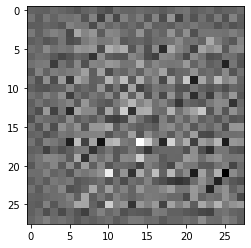

In [23]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

In [24]:
#discriminator
def cria_discriminador():
  network = tf.keras.Sequential()
  #14x14x64
  network.add(layers.Conv2D(filters = 64, strides= (2, 2), kernel_size = (5, 5), padding='same', input_shape=(28, 28, 1)))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(filters = 128, strides= (2, 2), kernel_size = (5, 5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [25]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [26]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [27]:
pred = discriminador(imagem_gerada, training=False) # logits format
pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00248177]], dtype=float32)>

In [28]:
tf.sigmoid(pred)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49937958]], dtype=float32)>

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [31]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [32]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [33]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [34]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [35]:
batch_size, dimensao_ruido

(256, 100)

In [36]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training=True)

    expected_output = discriminador(imagens, training=True)
    fake_output = discriminador(imagens_geradas, training = True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [37]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [38]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      #print(imagem_batch)
      treinamento(imagem_batch)
    print('Época: ', epoca+1)
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize=(10, 10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(imagens_geradas[i, :, :, 0]*127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Época:  1


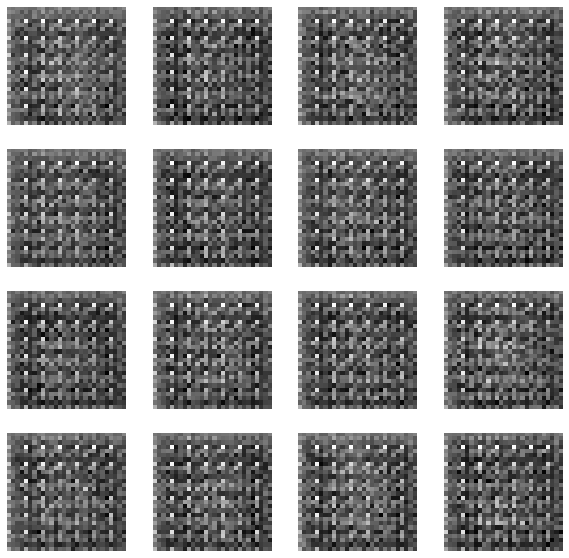

Época:  2


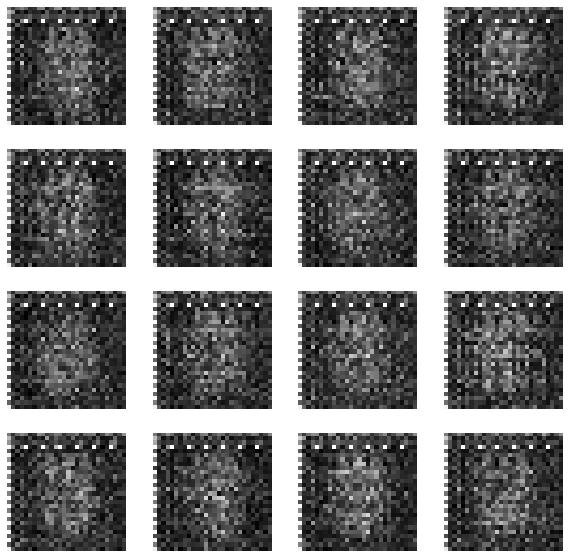

Época:  3


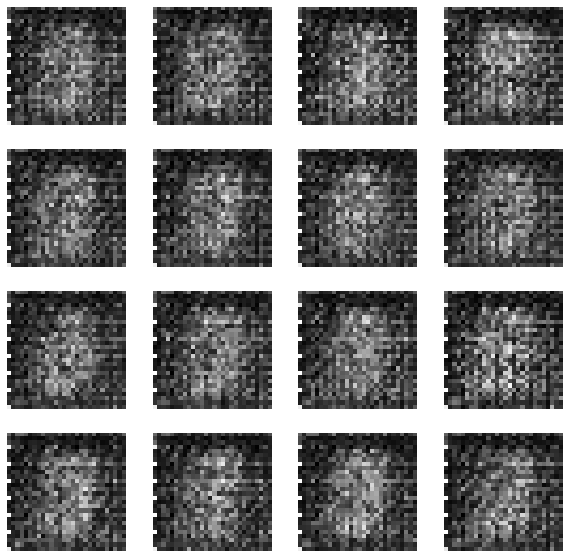

Época:  4


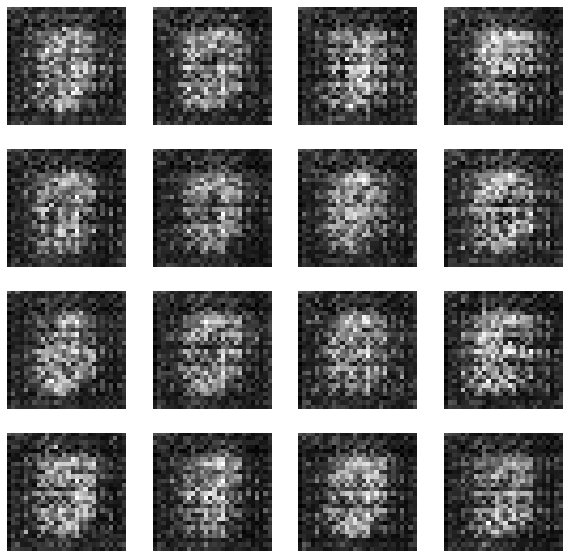

Época:  5


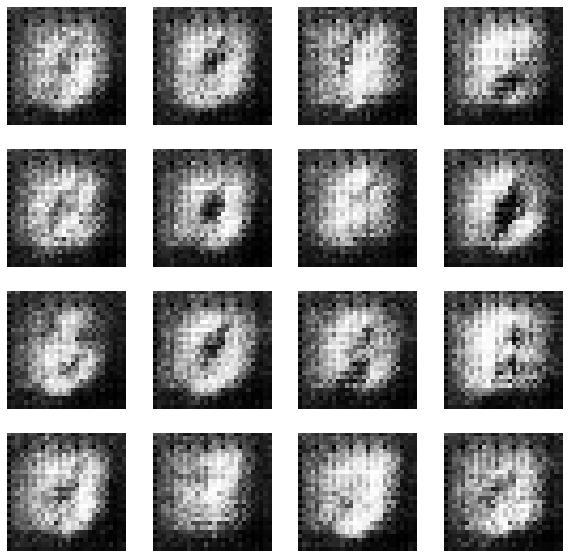

Época:  6


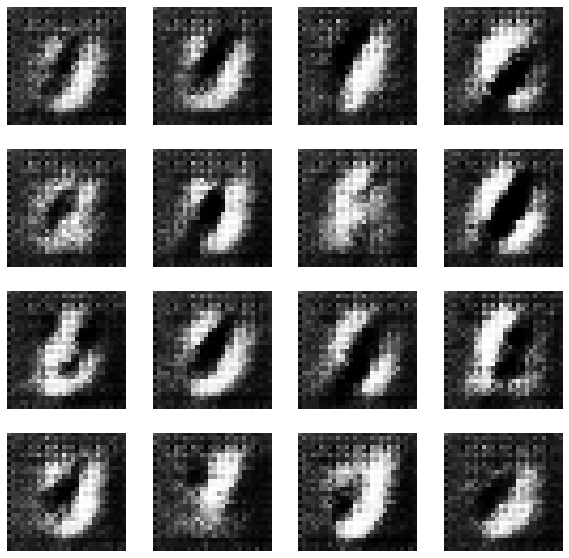

Época:  7


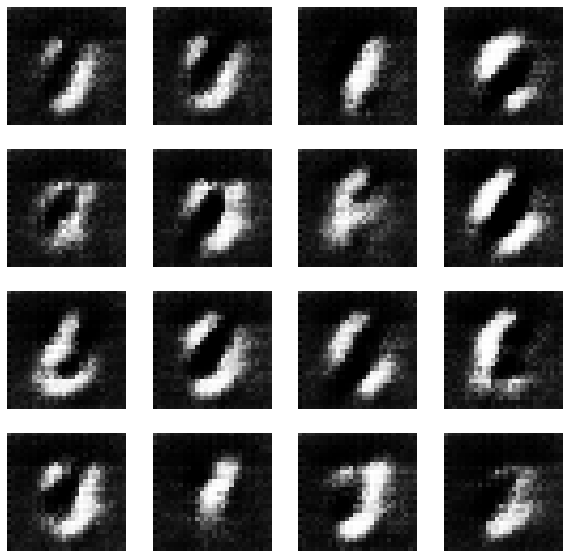

Época:  8


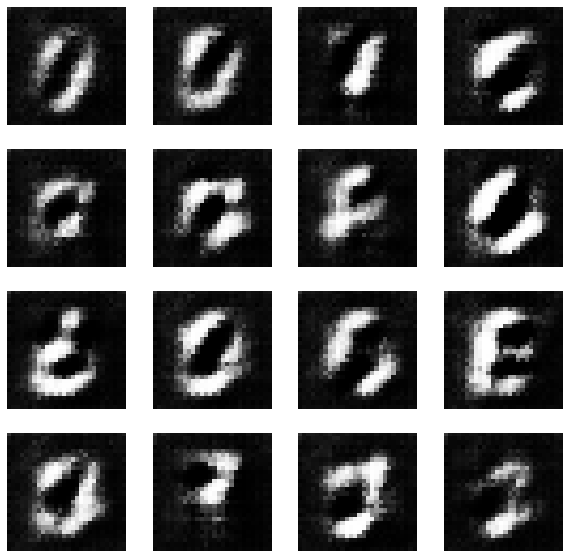

Época:  9


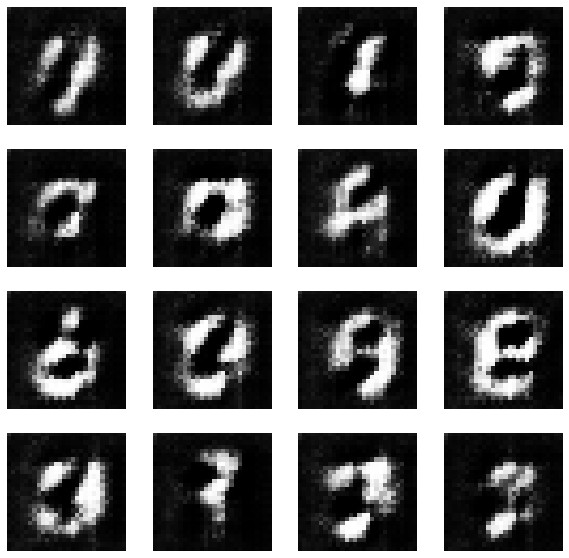

Época:  10


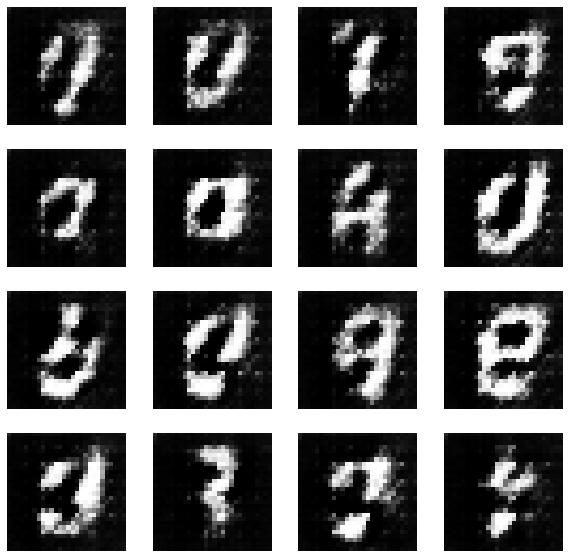

Época:  11


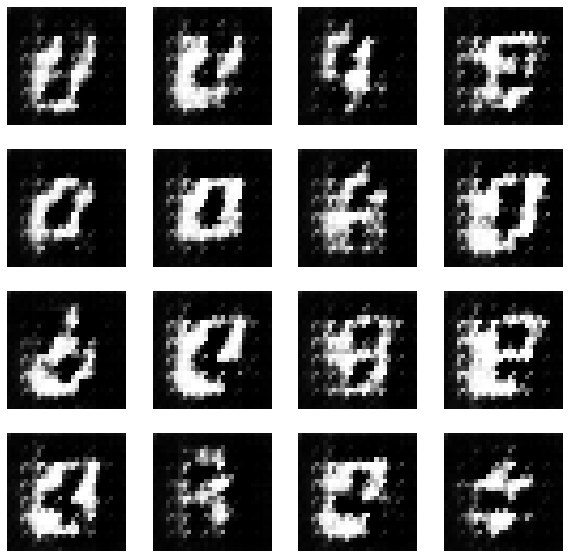

Época:  12


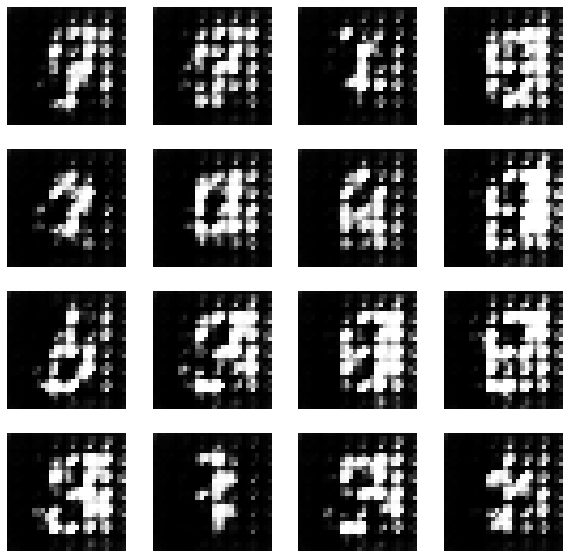

Época:  13


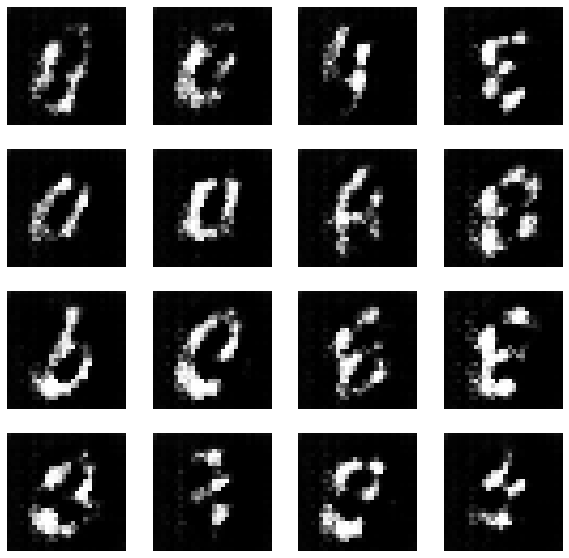

Época:  14


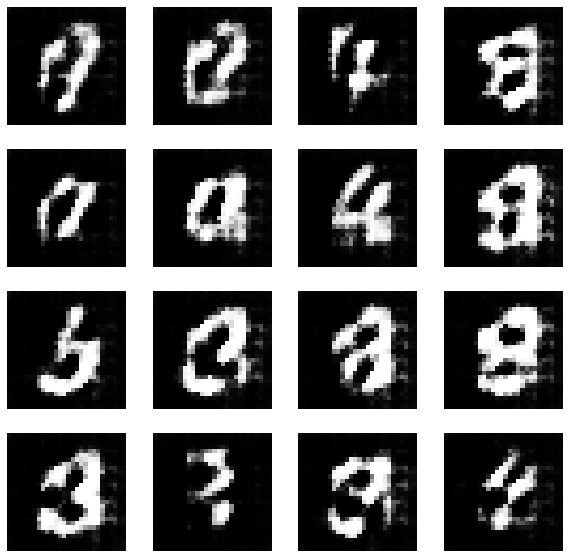

Época:  15


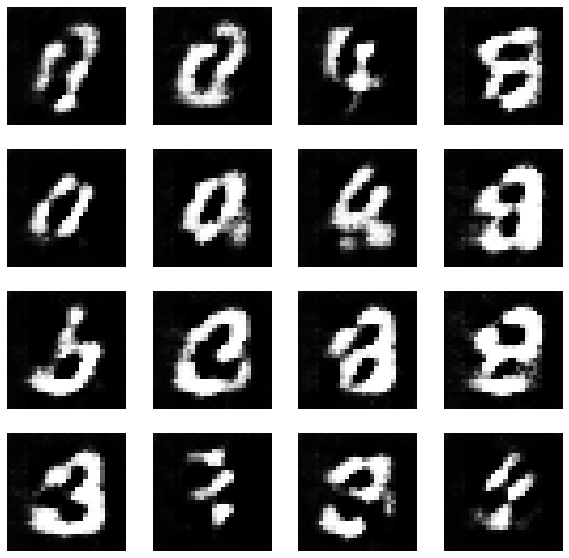

Época:  16


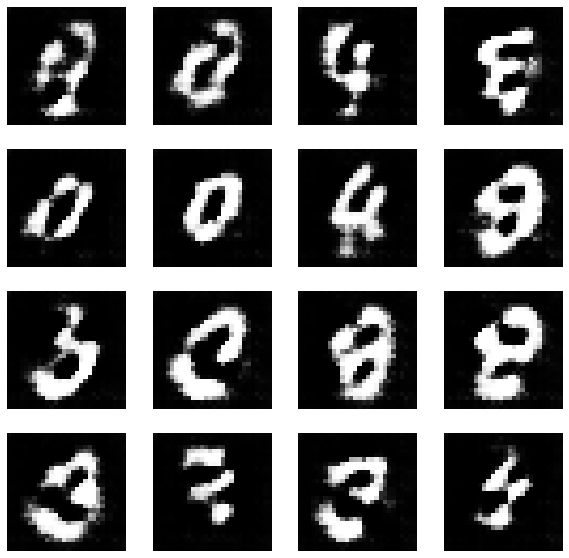

Época:  17


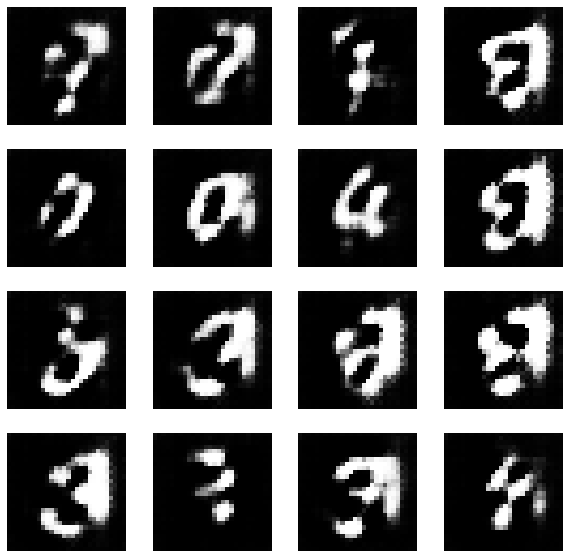

Época:  18


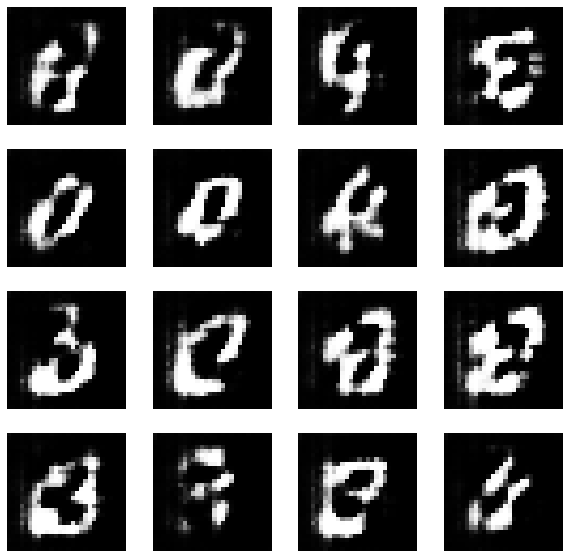

Época:  19


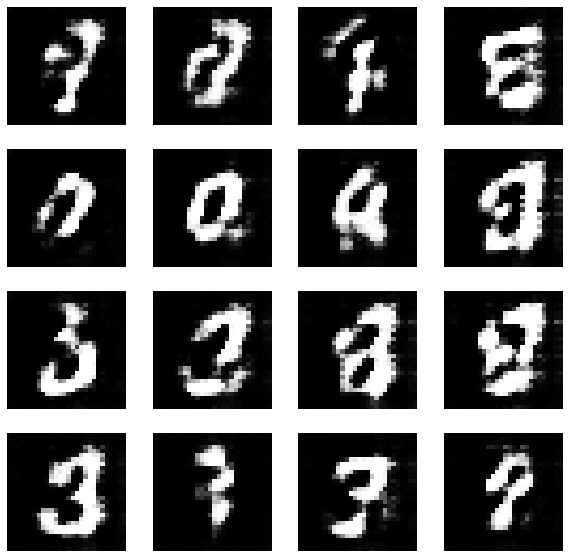

Época:  20


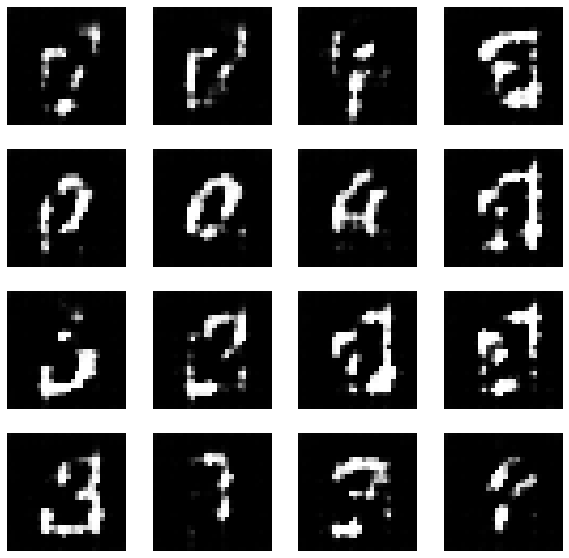

Época:  21


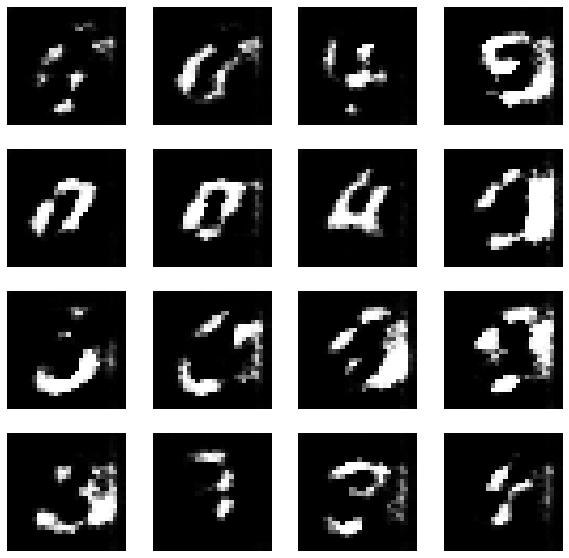

Época:  22


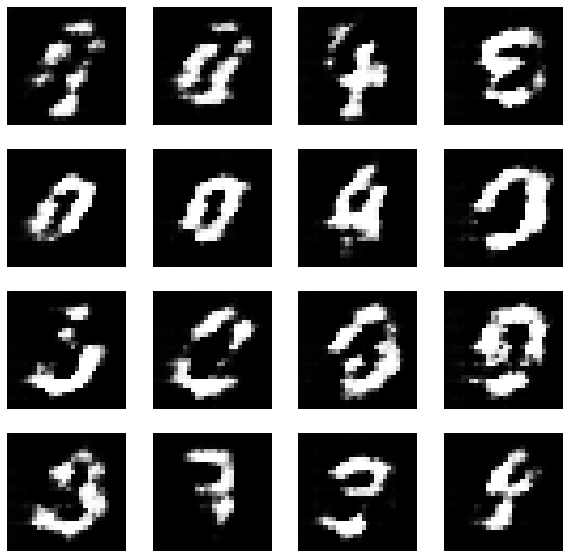

Época:  23


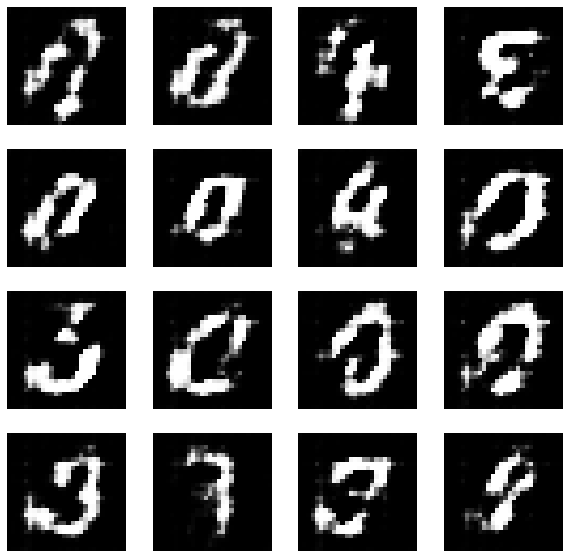

Época:  24


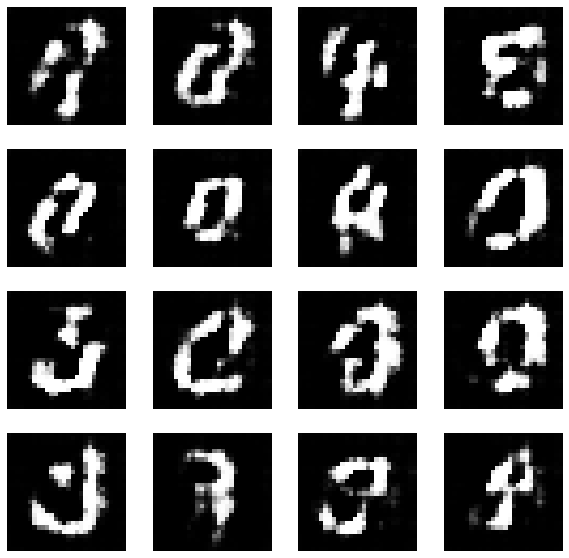

Época:  25


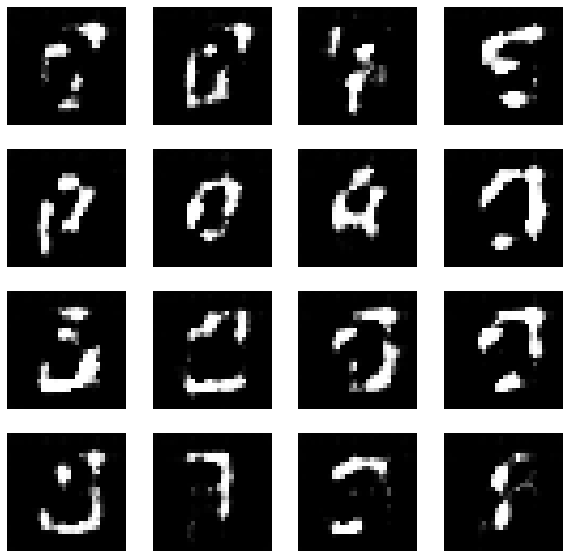

Época:  26


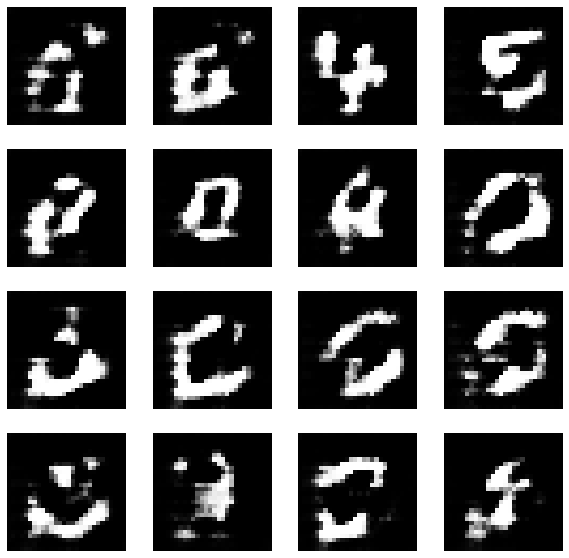

Época:  27


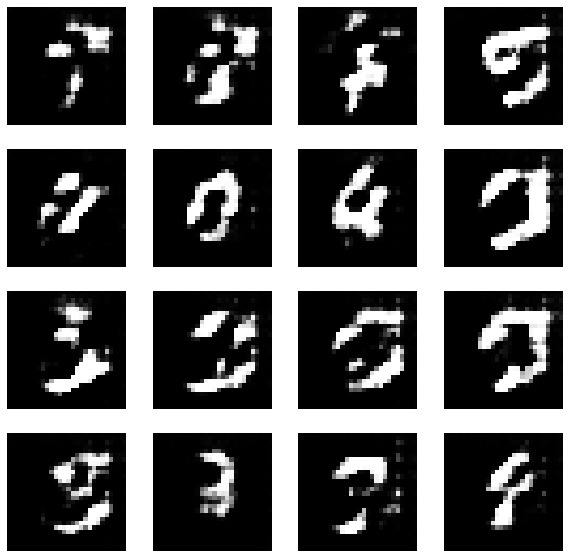

Época:  28


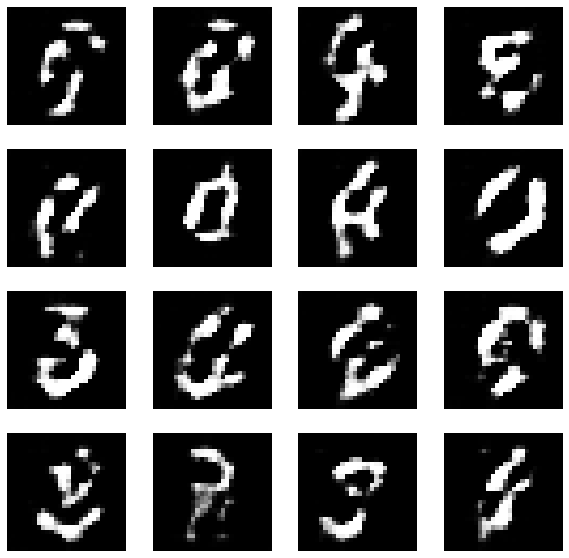

Época:  29


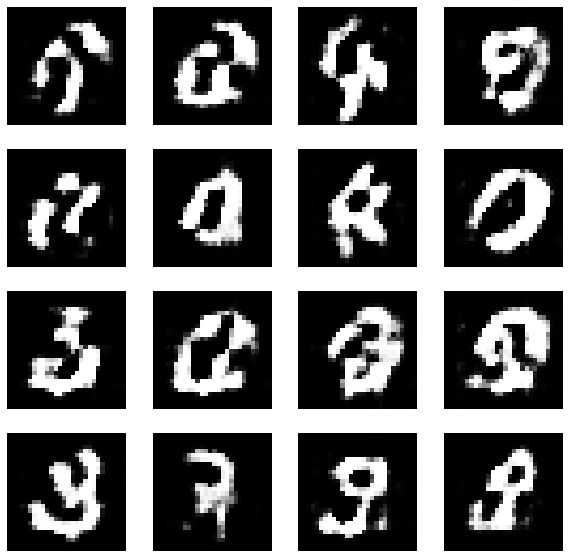

Época:  30


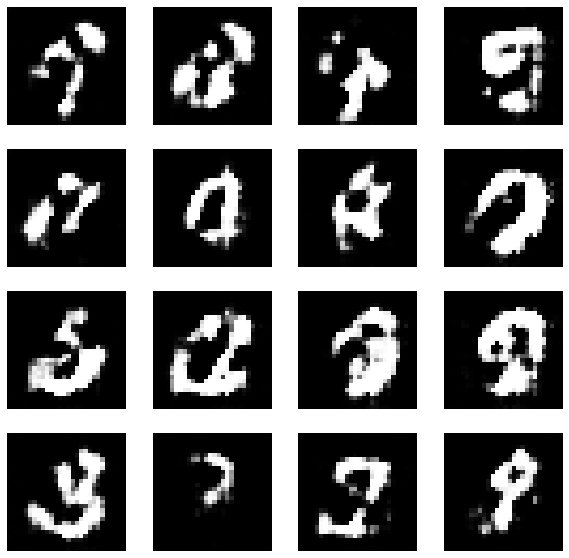

Época:  31


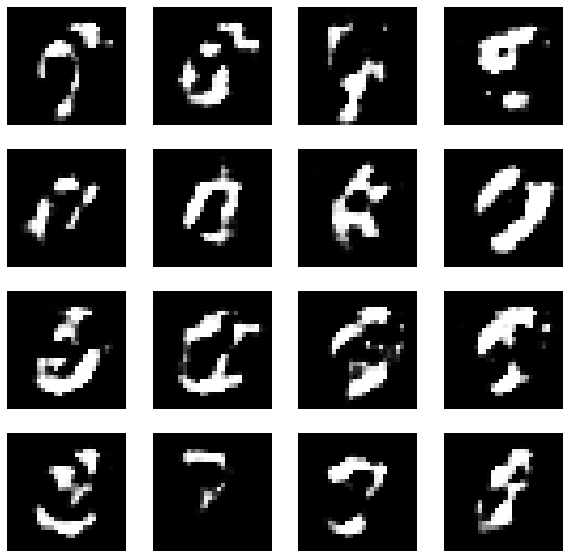

Época:  32


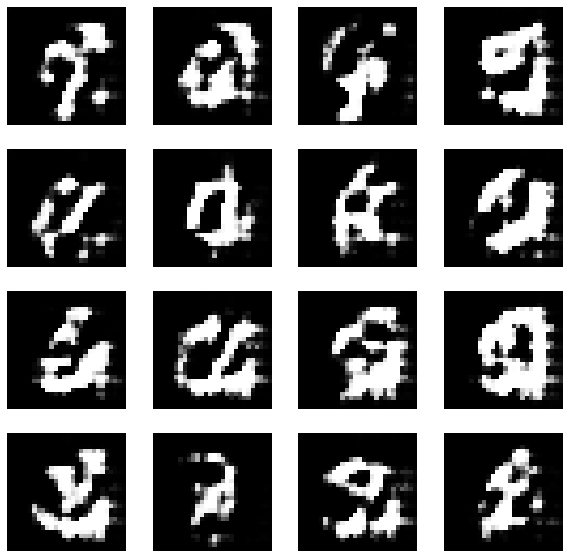

Época:  33


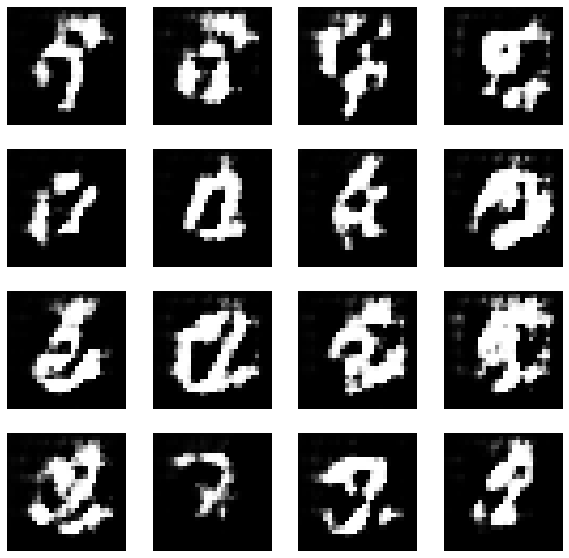

Época:  34


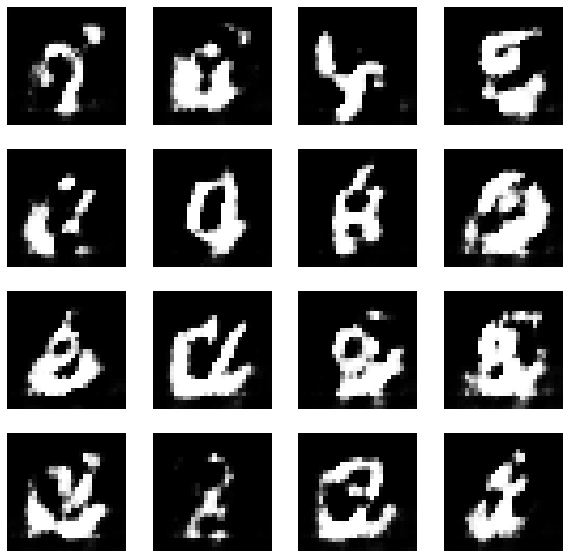

Época:  35


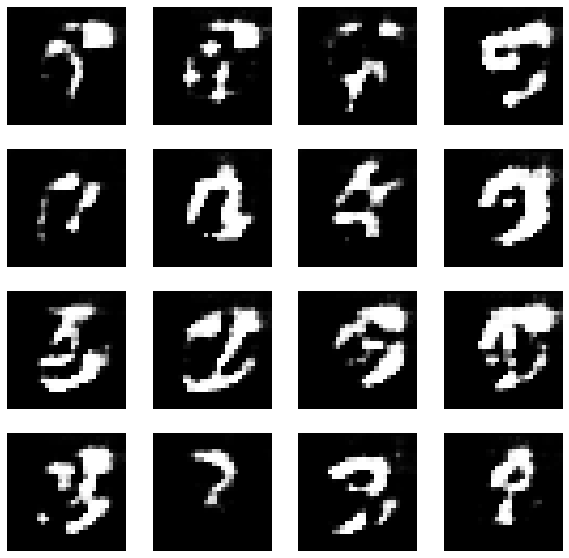

Época:  36


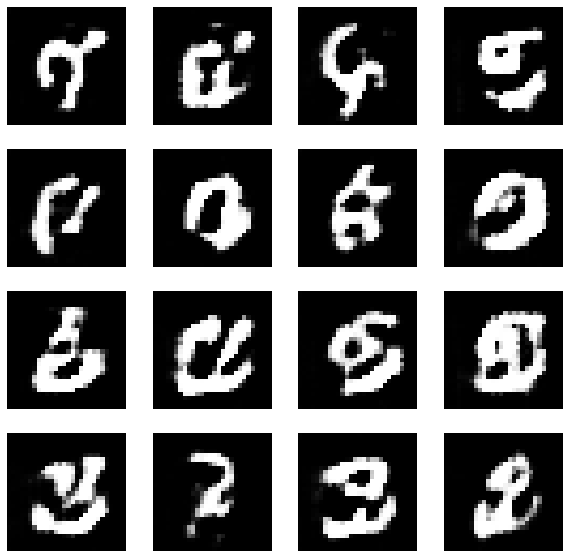

Época:  37


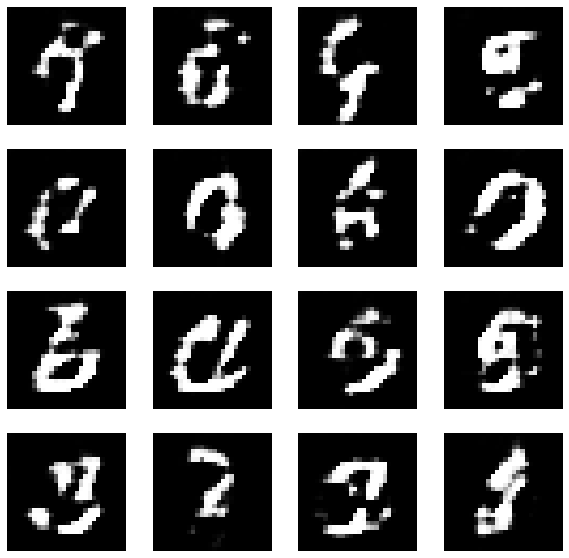

Época:  38


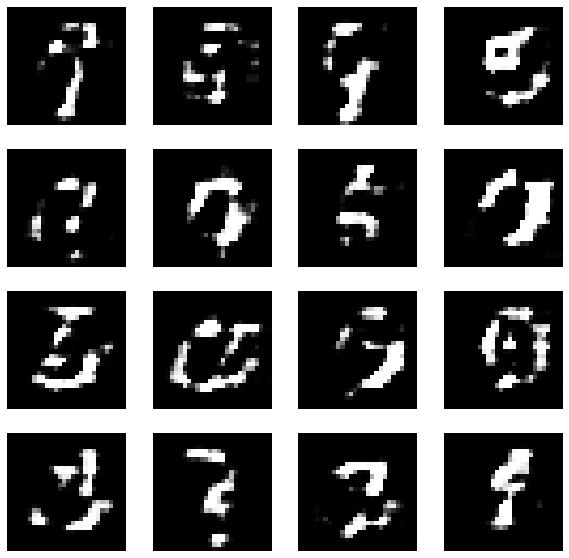

Época:  39


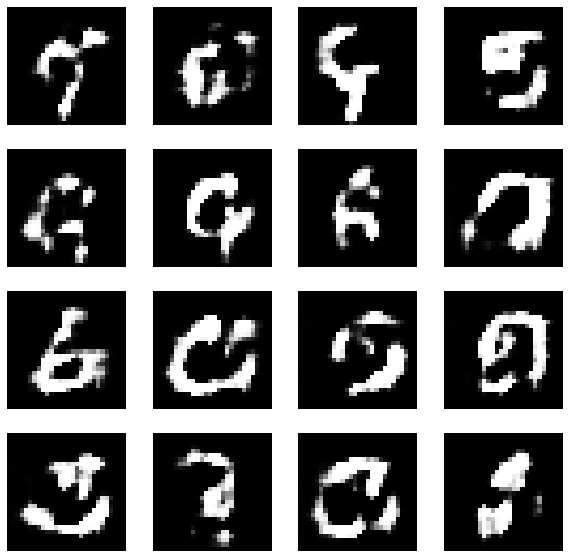

Época:  40


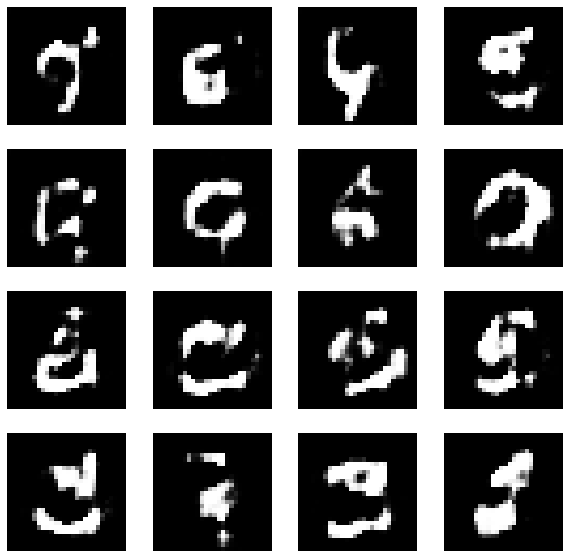

Época:  41


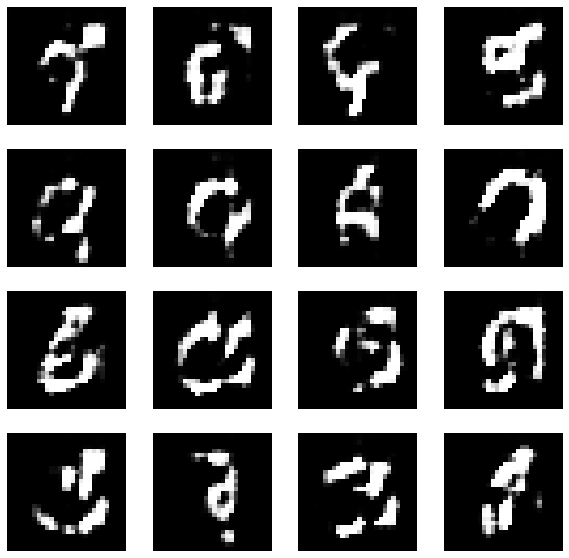

Época:  42


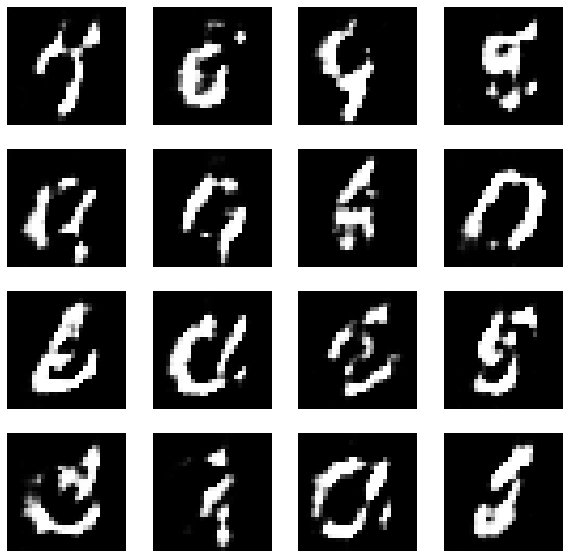

Época:  43


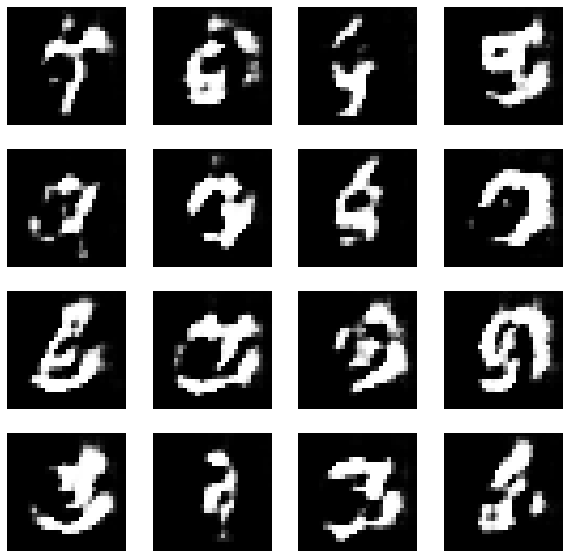

Época:  44


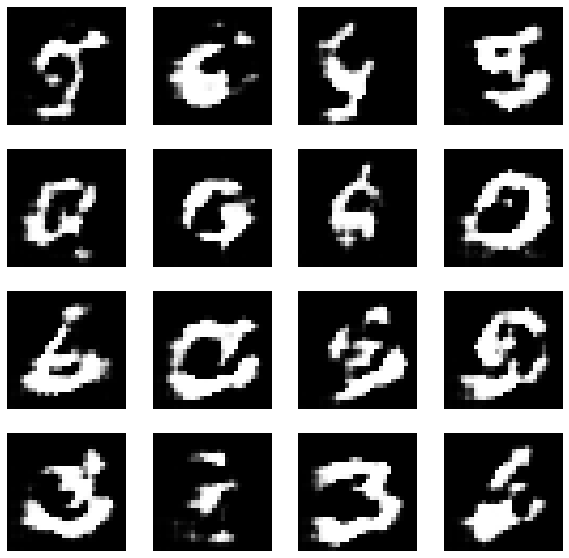

Época:  45


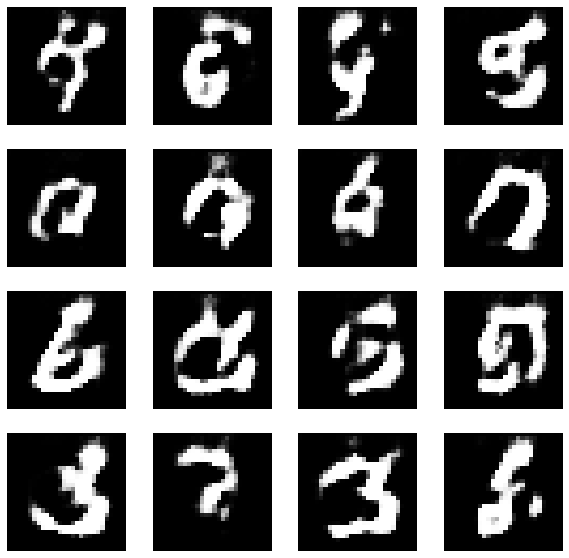

Época:  46


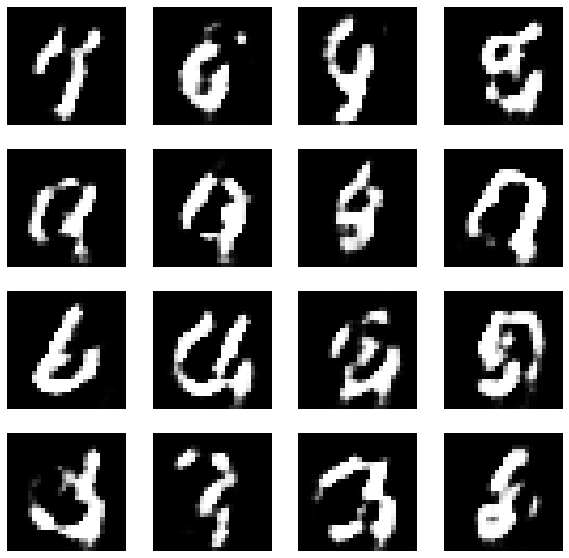

Época:  47


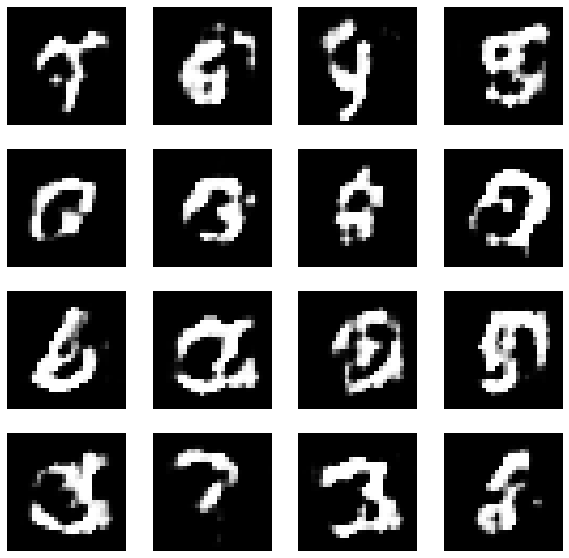

Época:  48


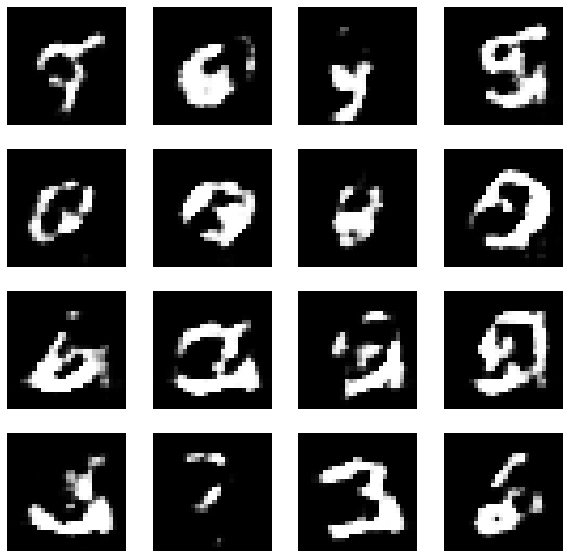

Época:  49


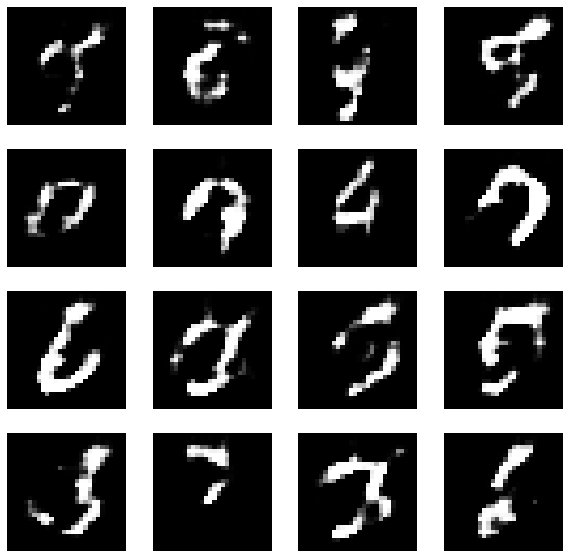

Época:  50


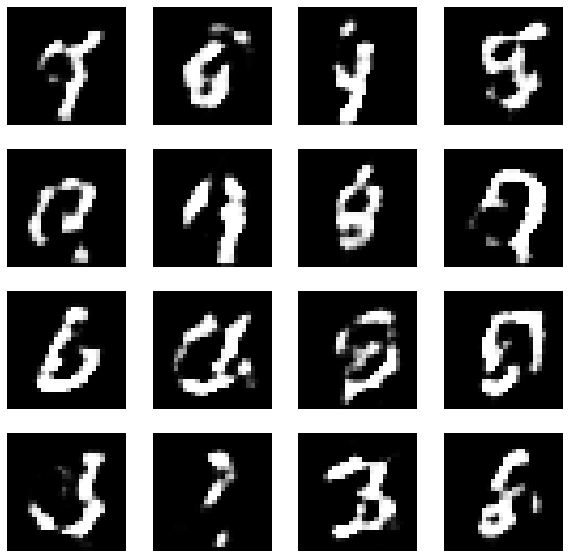

Época:  51


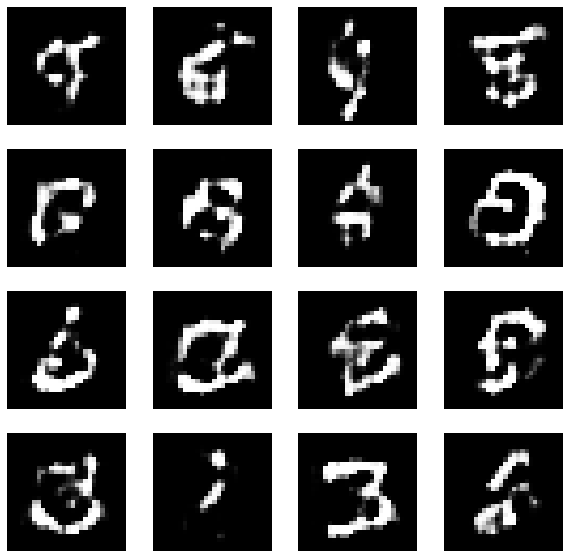

Época:  52


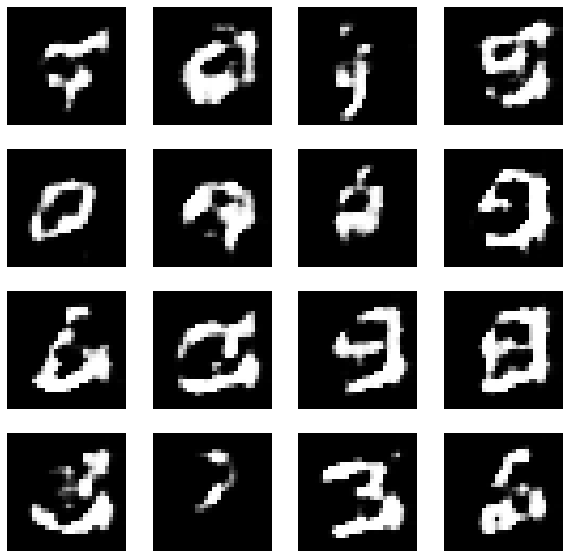

Época:  53


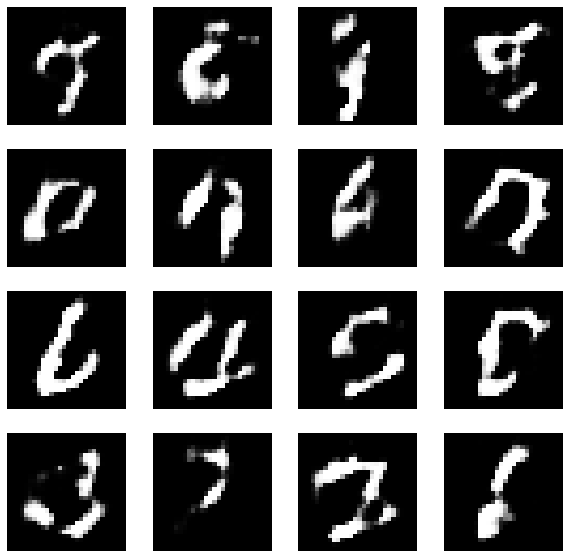

Época:  54


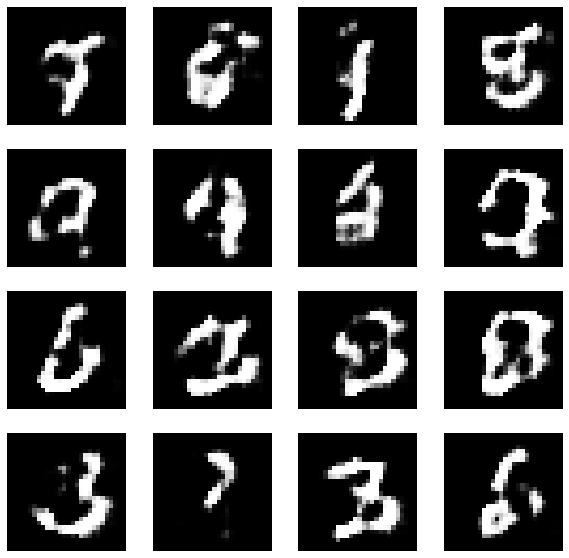

Época:  55


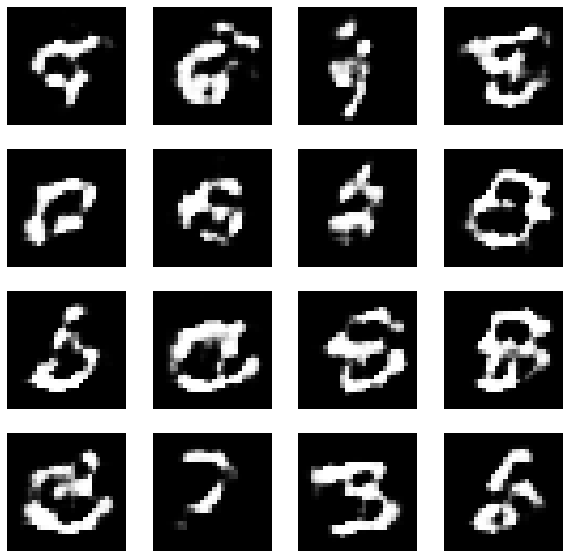

Época:  56


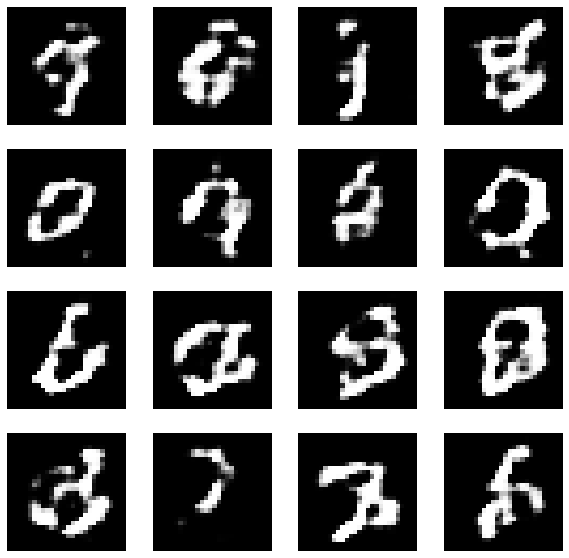

Época:  57


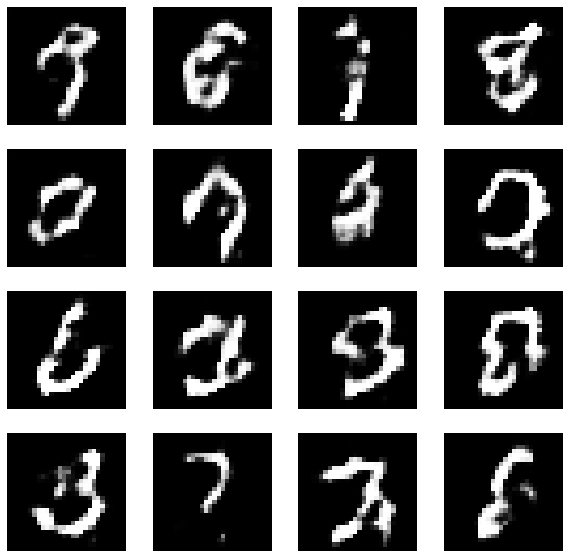

Época:  58


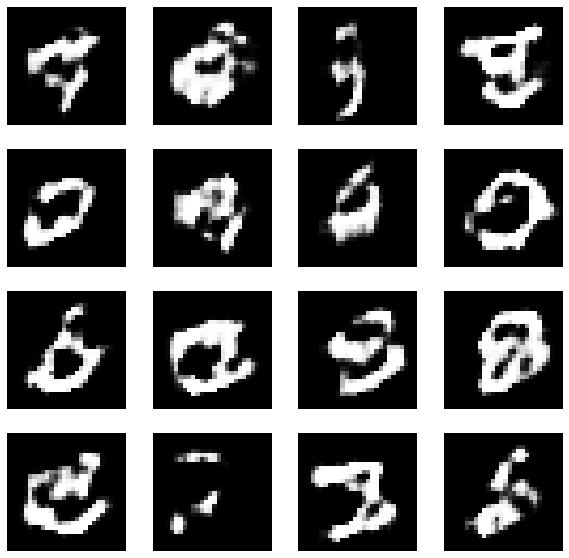

Época:  59


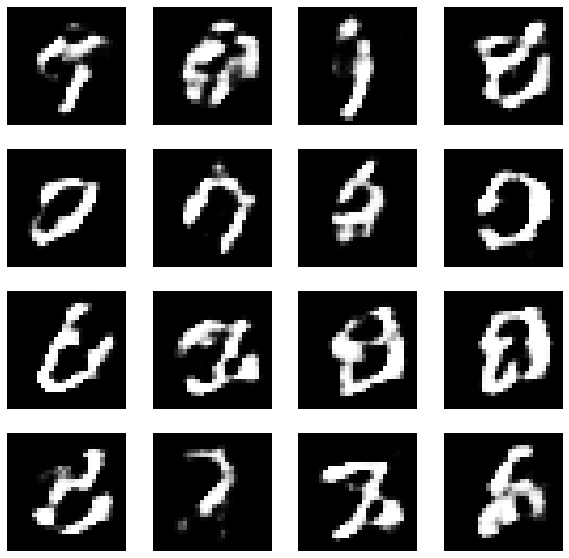

Época:  60


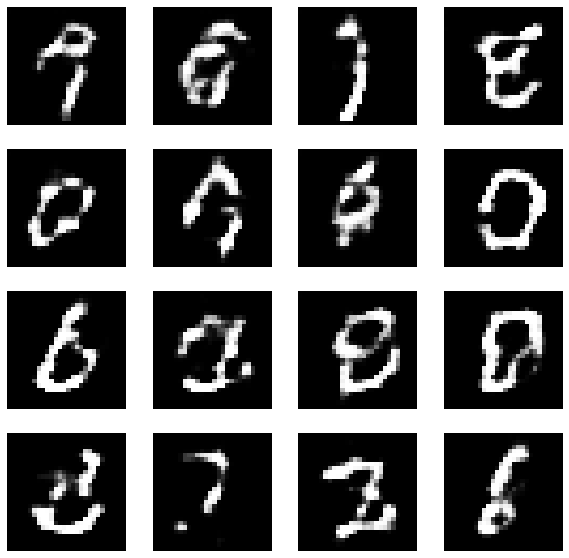

Época:  61


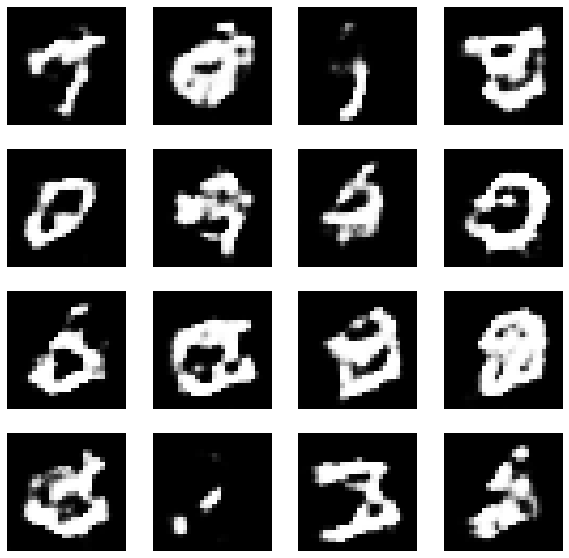

Época:  62


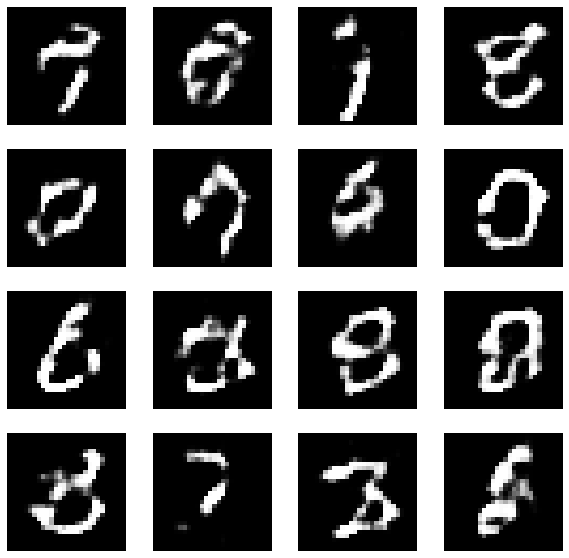

Época:  63


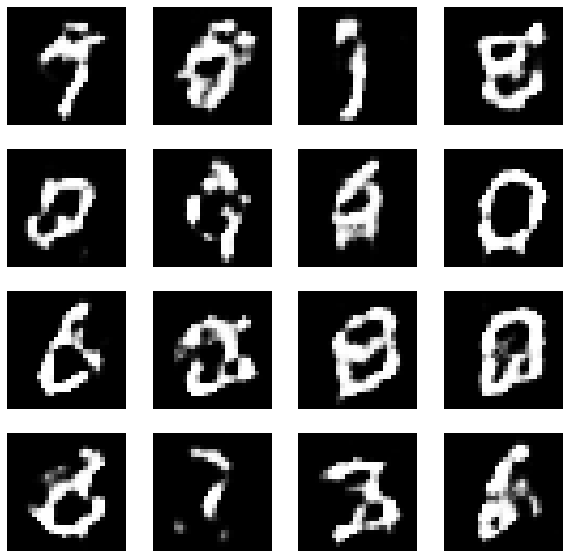

Época:  64


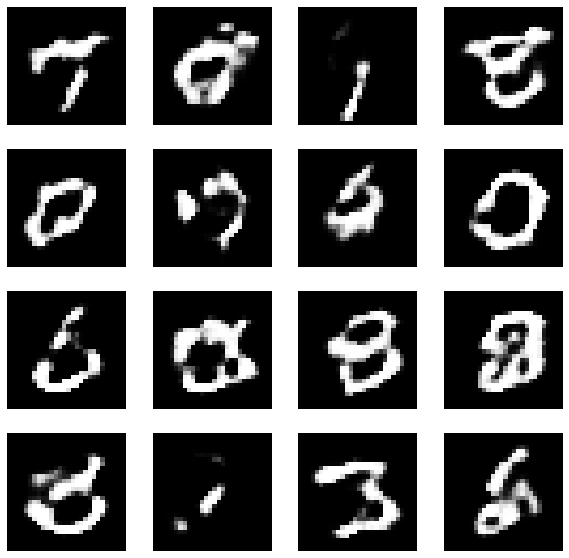

Época:  65


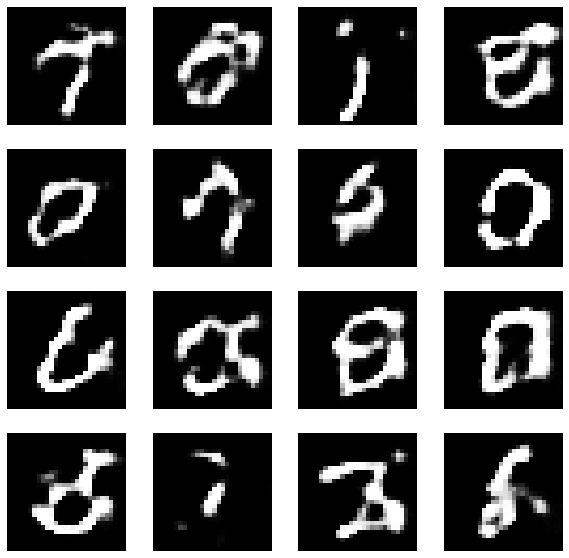

Época:  66


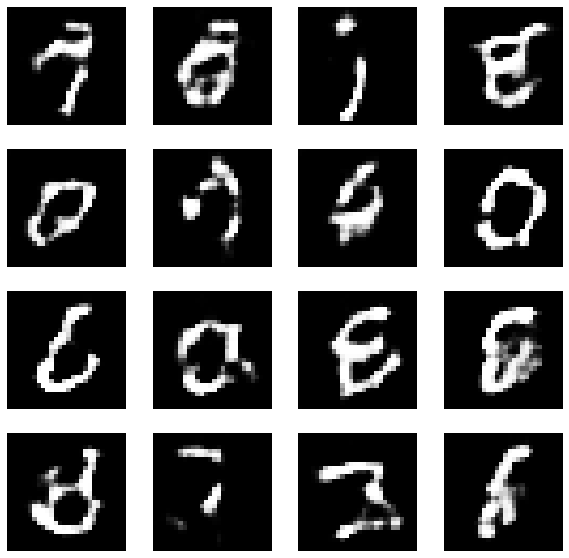

Época:  67


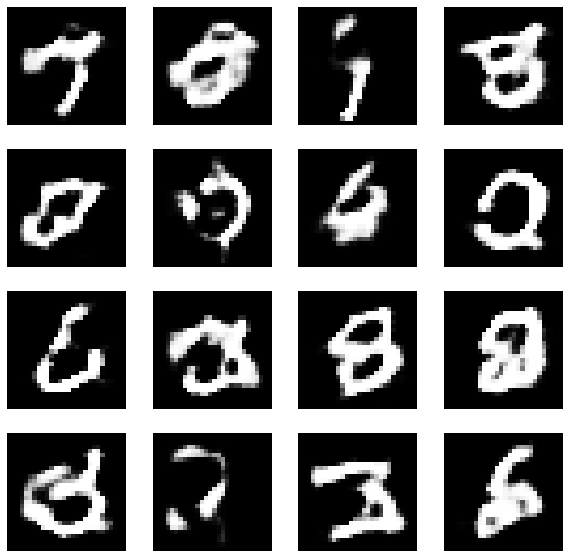

Época:  68


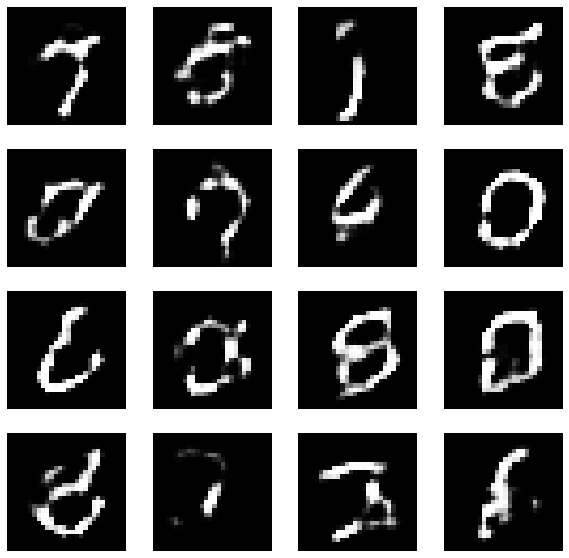

Época:  69


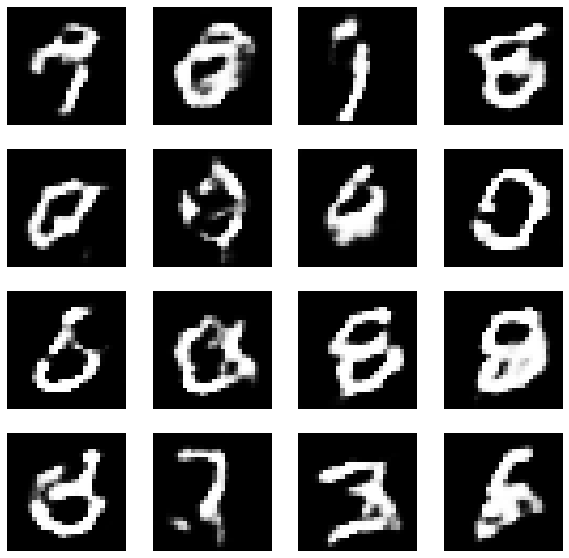

Época:  70


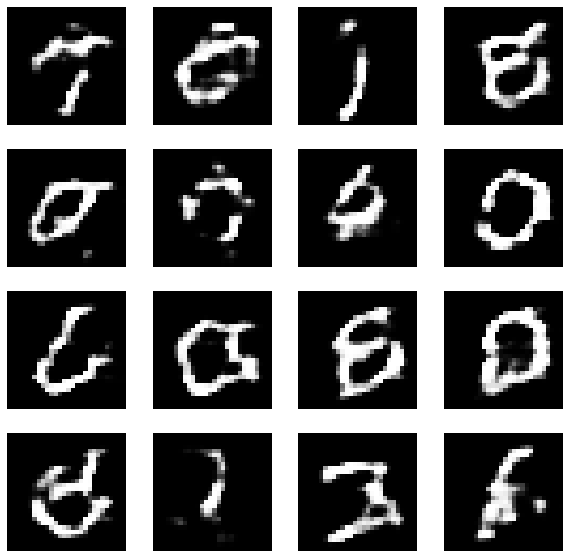

Época:  71


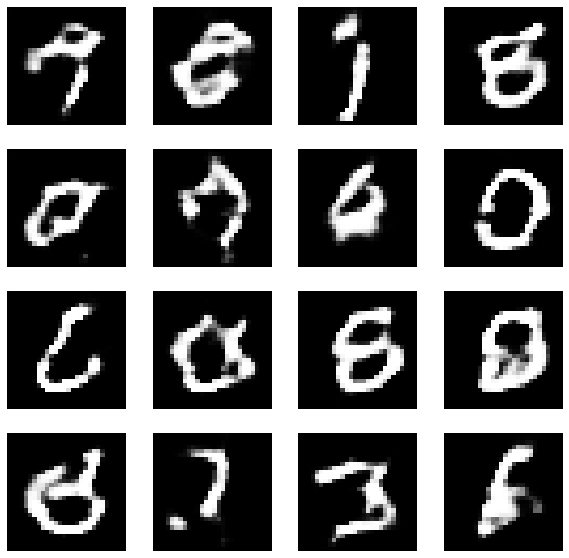

Época:  72


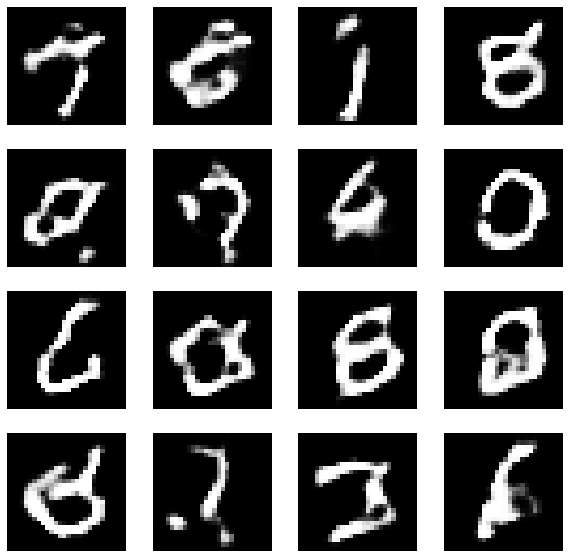

Época:  73


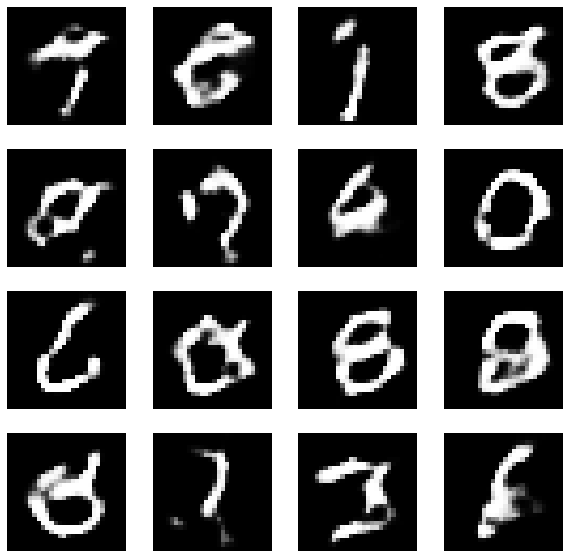

Época:  74


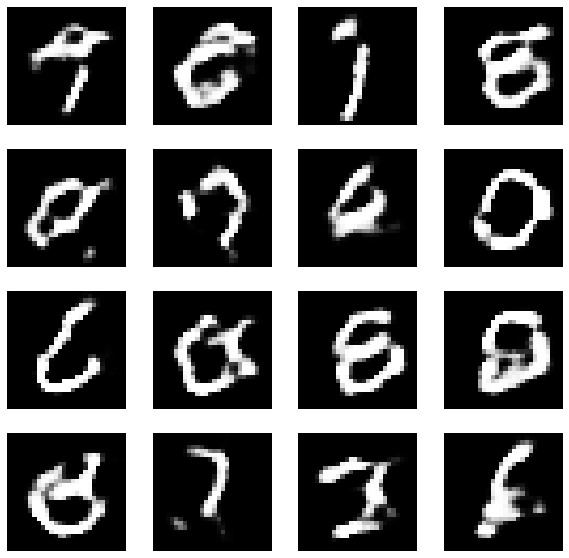

Época:  75


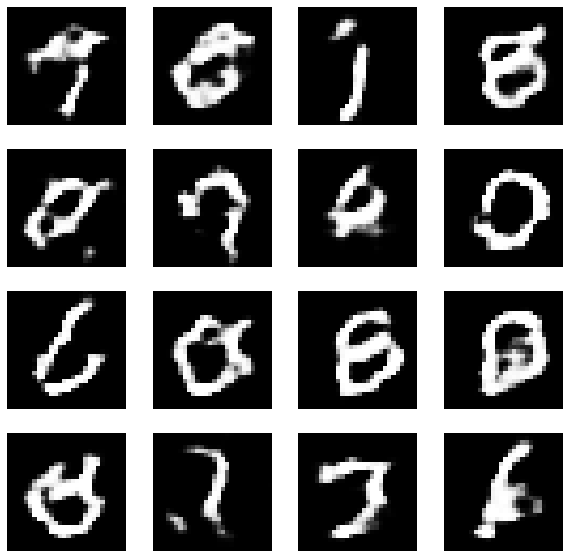

Época:  76


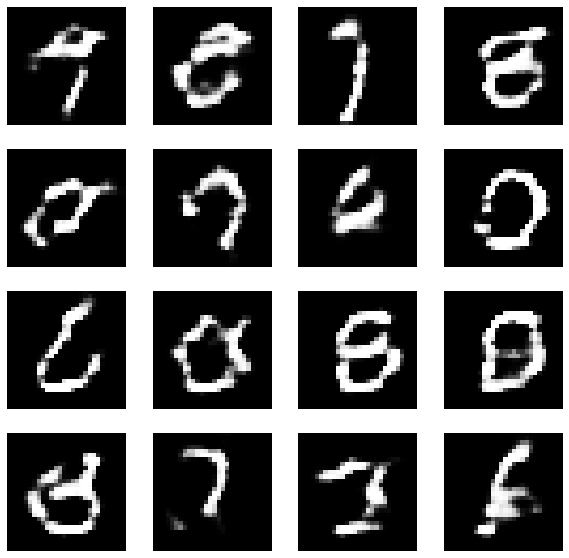

Época:  77


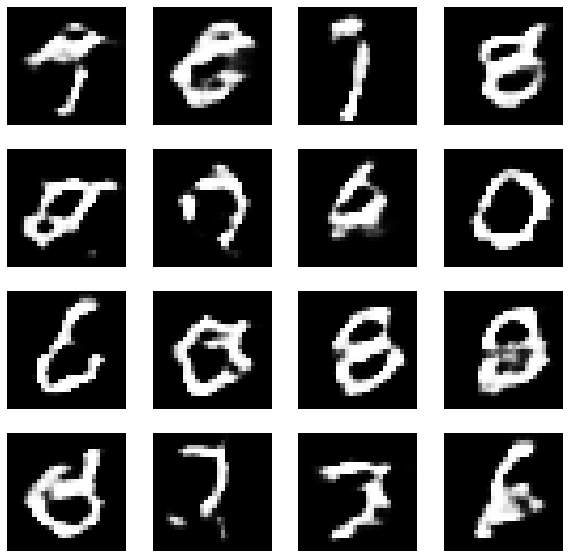

Época:  78


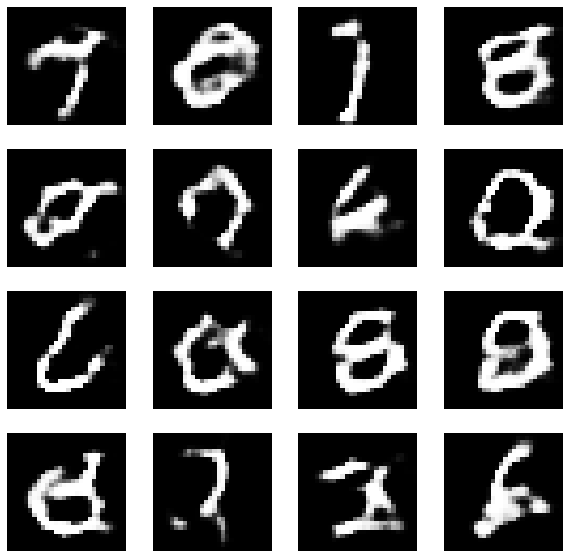

Época:  79


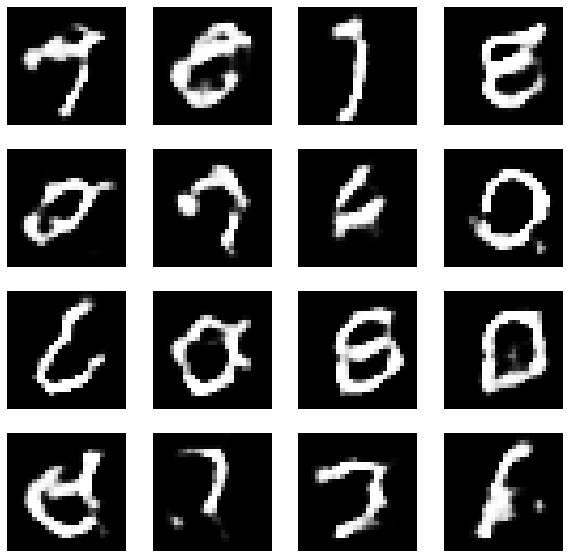

Época:  80


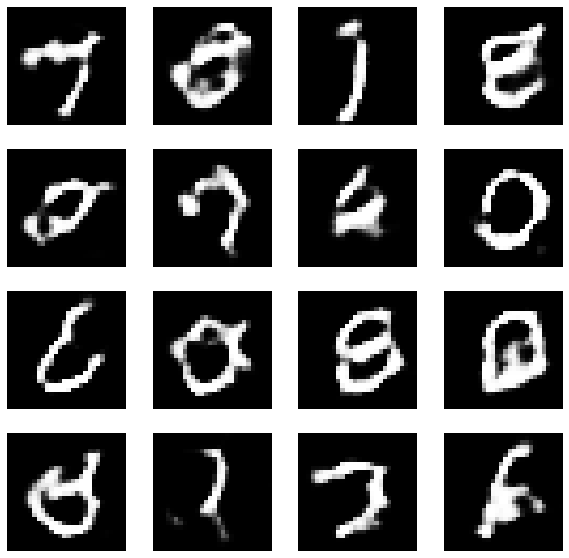

Época:  81


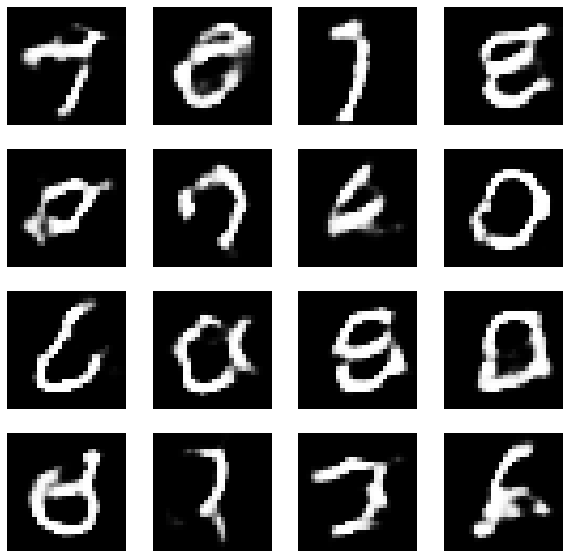

Época:  82


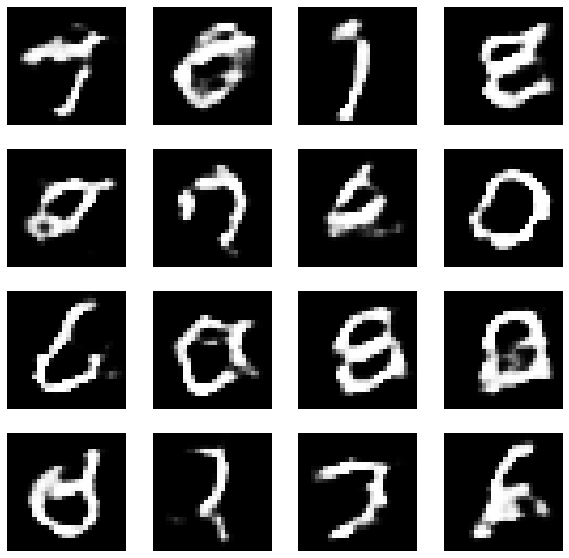

Época:  83


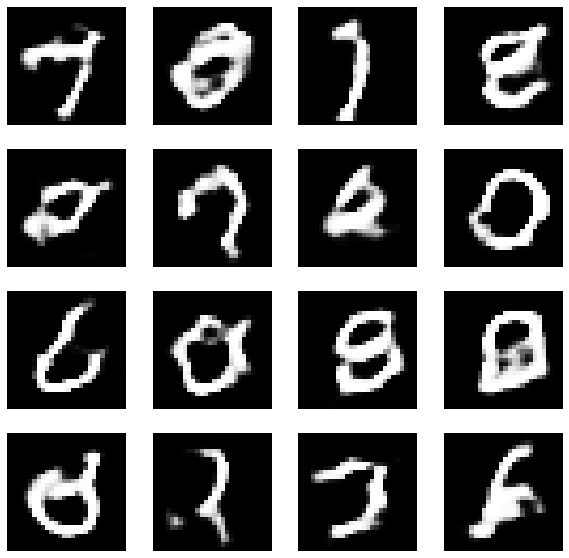

Época:  84


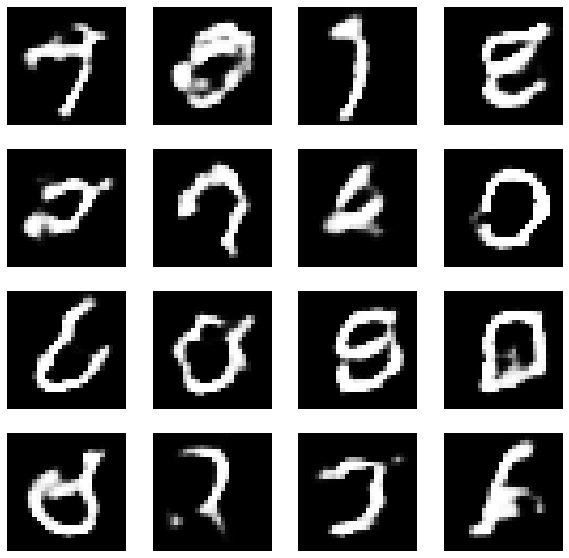

Época:  85


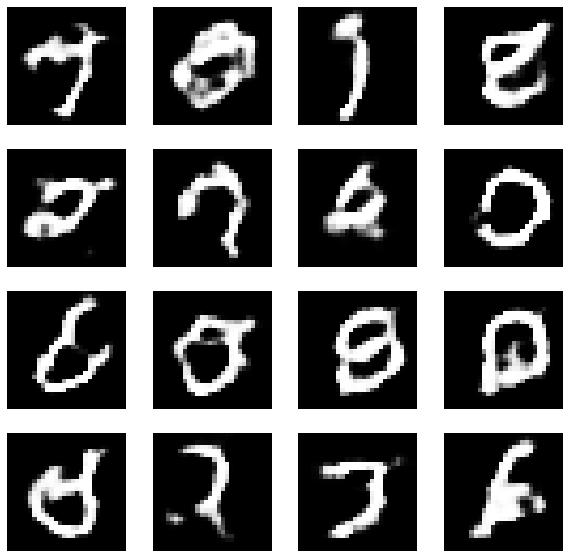

Época:  86


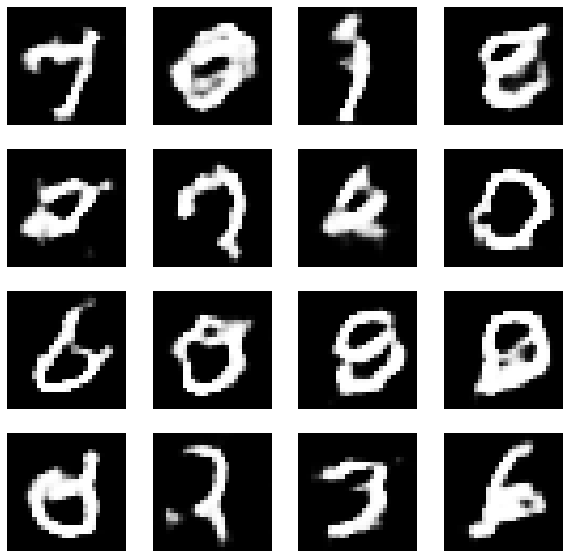

Época:  87


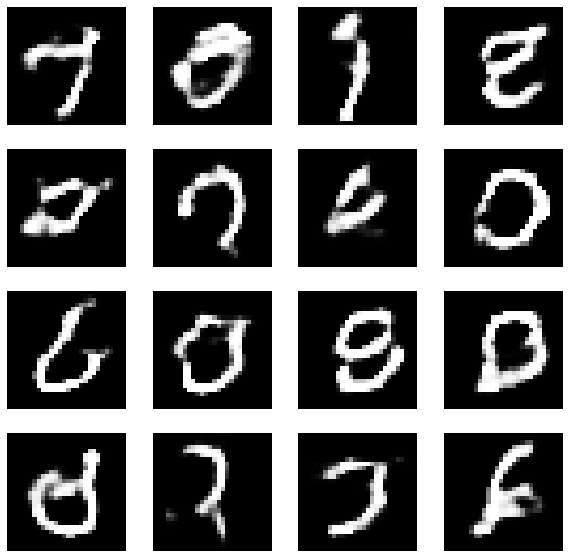

Época:  88


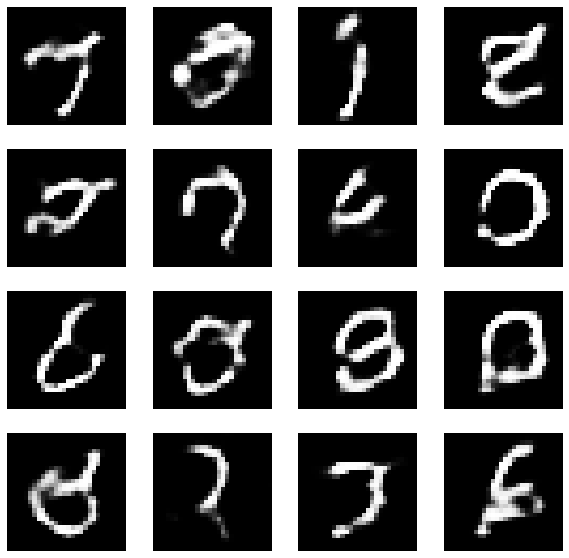

Época:  89


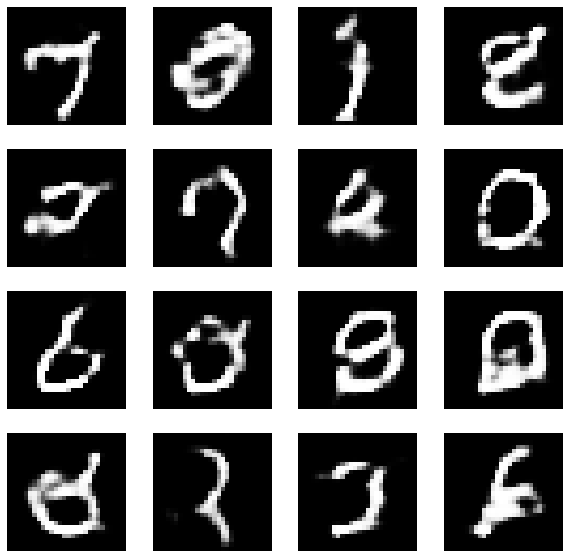

Época:  90


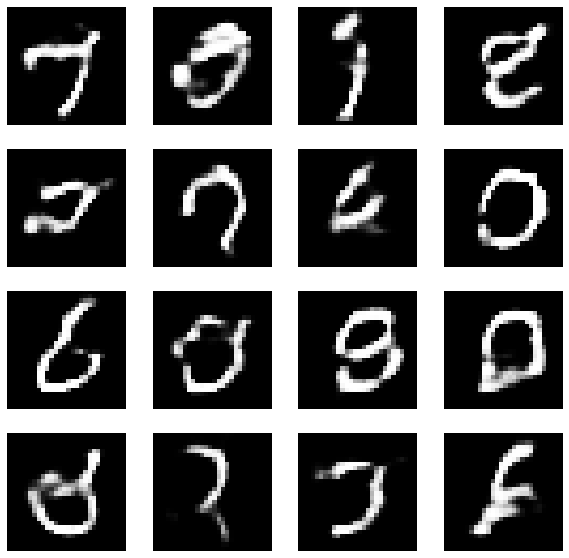

Época:  91


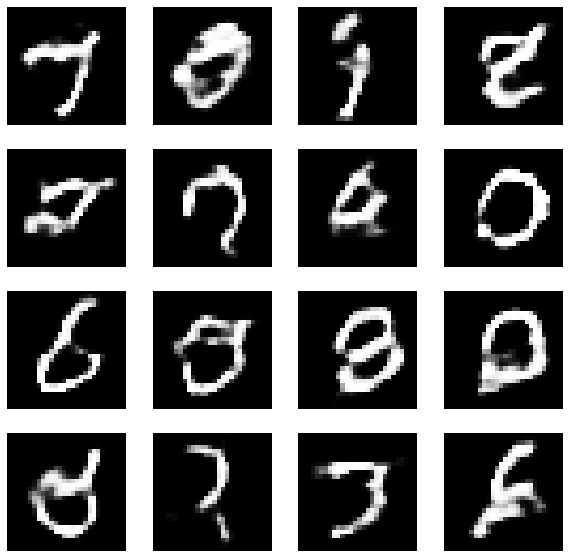

Época:  92


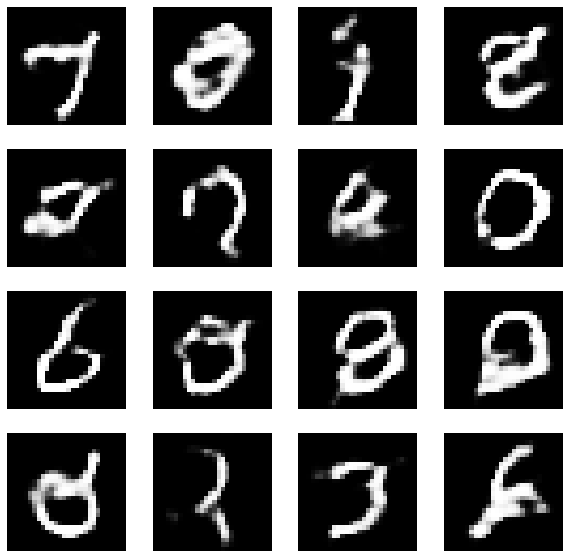

Época:  93


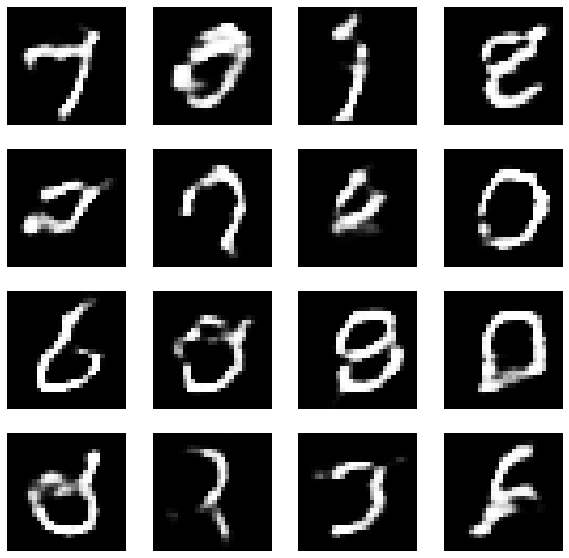

Época:  94


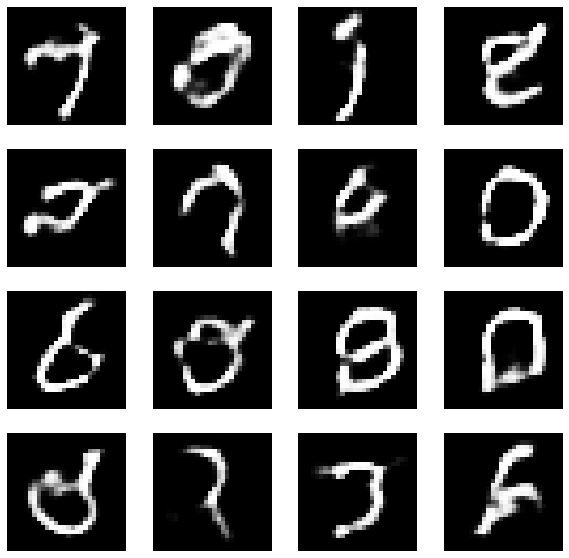

Época:  95


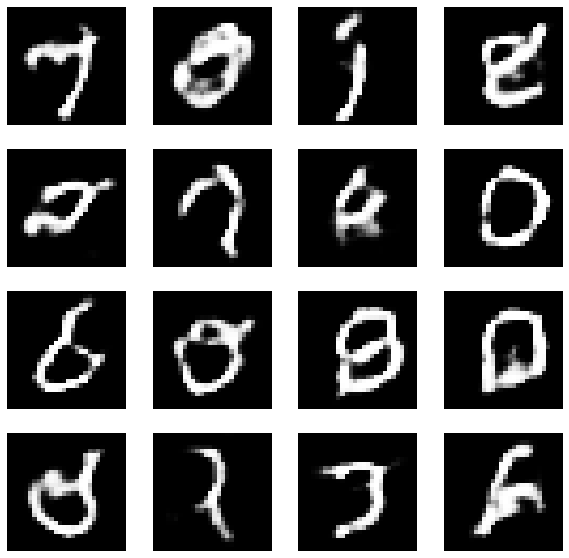

Época:  96


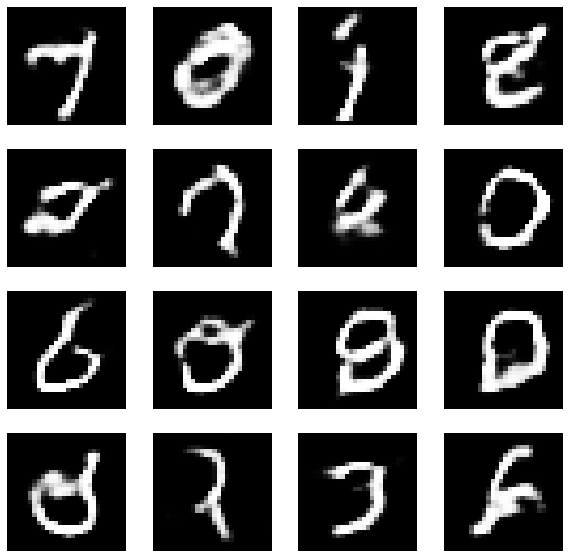

Época:  97


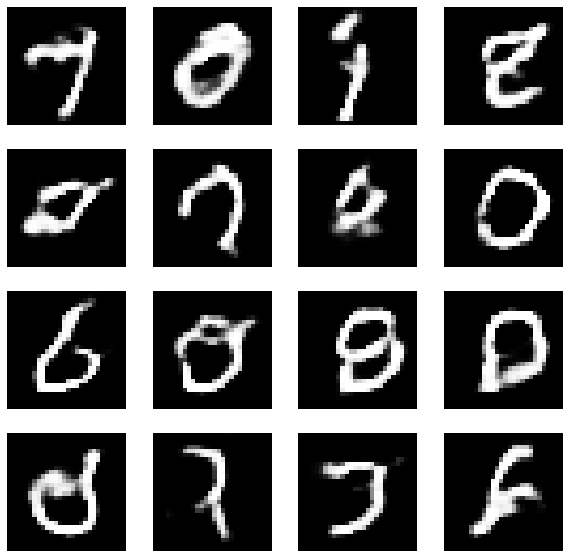

Época:  98


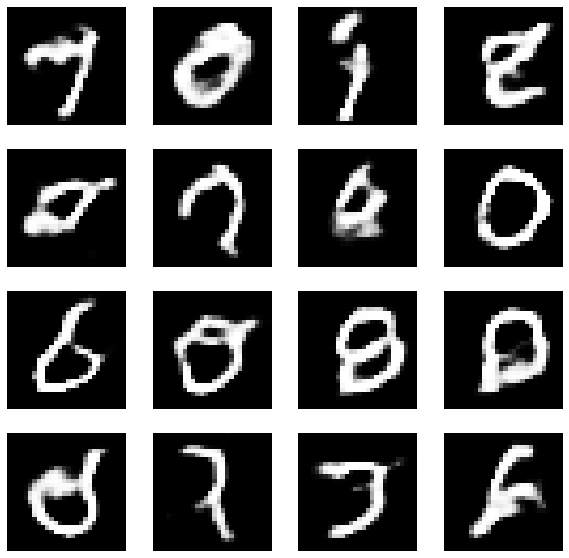

Época:  99


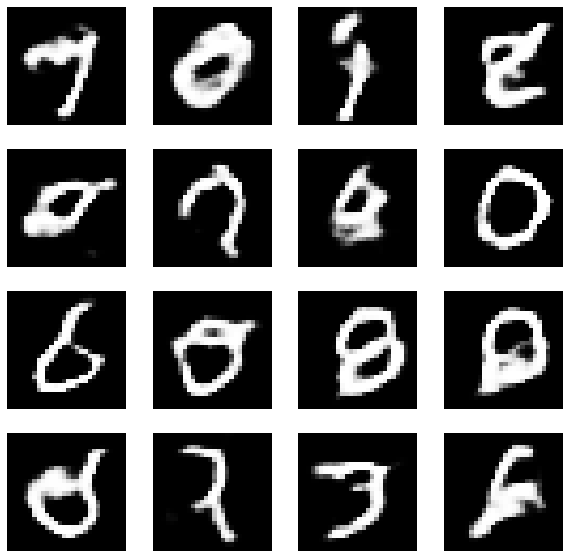

Época:  100


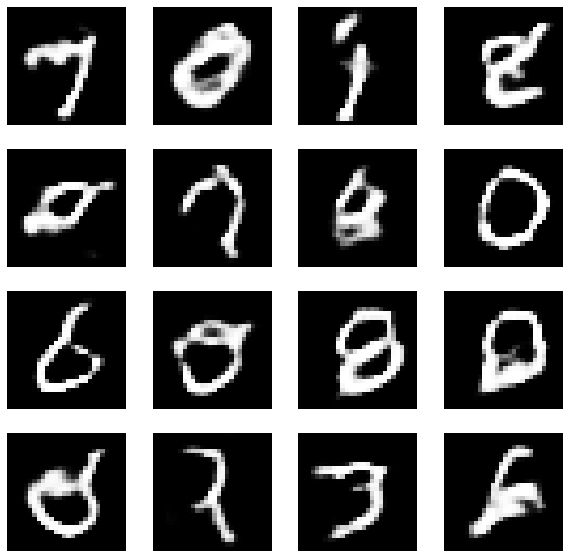

In [39]:
treina_gan(X_treinamento, epocas, imagens_teste)